# Create TCAC HCD Resource Opportunity Areas 2020 Dataset

In [27]:
import os
import sys
import pandas as pd, geopandas as gp, matplotlib.pyplot as plt, numpy as np
import json
import fiona
import requests
from arcgis.gis import GIS
from arcgis.features import GeoAccessor, GeoSeriesAccessor
from arcgis.features import FeatureLayerCollection

### Read in password from file

**Important:** Do not put passwords or sensitive information into this notebook. Read in from seperate file or add to DataViz creds file. 

In [28]:
def get_file_contents(filename):
    """ Given a filename,
        return the contents of that file
    """
    try:
        with open(filename, 'r') as f:
            # It's assumed our file contains a single line,
            # with our API key
            return f.read().strip()
    except FileNotFoundError:
        print("'%s' file not found" % filename)

In [29]:
pass_txt = '../../../../passwords/arcgis_enterprise_pass.txt'
password = get_file_contents(pass_txt)

### Connect to BAM Enterprise Portal

**Important:** Must be connected to VPN if working outside of Metro Center

In [30]:
gis = GIS("https://arcgis.ad.mtc.ca.gov/portal/", "jcroff", password)

# Publish updated 2020 HCD/TCAC Resource Opportunity Dataset to staging group 

In [31]:
!ls ../../../../../../Box/

#All Staff Share
8_Plan Document
BASIS - UrbanSim Coordination Meeting.boxnote
BASIS Email to Locals_draft.docx
BASIS External Communication.boxnote
BASIS Land Use Data Store
BASIS Update for ABAG Executive Board.boxnote
BCDC_Jurisdiction_Maps
CalEnviroScreen 3 Map Update
Code Work
Combined Modeling Dataviz and ED&F Meetings
Current Horizon Large General Input Data
DEIR 2017
DataViz Library
DataViz Projects
DataViz Software & Users
Datasets Needing Review
ECPP
Employee Self Evaluations
FHSZ
FSP (T3)
For Josh to Print
For Josh: to Plot
Fragile Housing
GIS (shapefiles)
GIS_Team_Sharing
GitHub Cleanup.boxnote
HP Plotters and Cannon
Horizon and Plan Bay Area 2050
Installing Canon Fiery Postscript RIP drivers
Interim_Data
Joshua Documents
Las Vegas
MOTM
Meeting 3- June 29
OBAG2
Office Hours
Open Data Website Images
OppSitesData
PBA_2040_Transportation_Project_Maps-2017
PPA boundaries check.mpk
Plan Bay Area Maps
Planning - Workplan 2019-2020
Planning FY 2017-18 DRAFT workplans
Public Releas

In [32]:
ls '../../../../../../Box/DataViz Projects/Data Analysis and Visualization/Housing Element Site Mapping and Pre-screening/Data/tabular'

VehicleMilesTraveled.csv          ctcac_hcd_final_2020_public.xlsx


In [33]:
data_dir = '../../../../../../Box/DataViz Projects/Data Analysis and Visualization/Housing Element Site Mapping and Pre-screening/Data/tabular'

In [34]:
resource_areas = pd.read_excel(os.path.join(data_dir,'ctcac_hcd_final_2020_public.xlsx'),
                              dtype={'Census Tract':str,
                                    'Census Block Group':str,
                                    'County ID':str})

In [35]:
resource_areas.head(5)

,Census Tract,Census Block Group,County,County ID,Region,Economic Domain Score (by region),Environmental Domain Score (by region),Education Domain Score (by region),Composite Index Score,Final Category
0,06001400100,NaN,Alameda,06001,Bay Area Region,0.826,0.406,0.736,0.433,High Resource
1,06001400200,NaN,Alameda,06001,Bay Area Region,0.935,0.754,0.794,0.683,Highest Resource
2,06001400300,NaN,Alameda,06001,Bay Area Region,0.911,0.741,0.340,0.235,High Resource
3,06001400400,NaN,Alameda,06001,Bay Area Region,0.877,0.747,0.429,0.289,High Resource
4,06001400500,NaN,Alameda,06001,Bay Area Region,0.802,0.865,0.586,0.397,High Resource


In [36]:
resource_areas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10144 entries, 0 to 10143
Data columns (total 10 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Census Tract                            10144 non-null  object 
 1   Census Block Group                      3093 non-null   object 
 2   County                                  10144 non-null  object 
 3   County ID                               10143 non-null  object 
 4   Region                                  10144 non-null  object 
 5   Economic Domain Score (by region)       9635 non-null   float64
 6   Environmental Domain Score (by region)  9635 non-null   float64
 7   Education Domain Score (by region)      9635 non-null   float64
 8   Composite Index Score                   8786 non-null   float64
 9   Final Category                          9635 non-null   object 
dtypes: float64(4), object(6)
memory usage: 792.6+ KB


In [37]:
resource_areas[resource_areas['Region'] == 'Bay Area Region'].shape

(1513, 10)

In [38]:
resource_areas[((resource_areas['Region'] == 'Bay Area Region') & 
                (resource_areas['Census Block Group'].isnull()))]

,Census Tract,Census Block Group,County,County ID,Region,Economic Domain Score (by region),Environmental Domain Score (by region),Education Domain Score (by region),Composite Index Score,Final Category
0,06001400100,NaN,Alameda,06001,Bay Area Region,0.826,0.406,0.736,0.433,High Resource
1,06001400200,NaN,Alameda,06001,Bay Area Region,0.935,0.754,0.794,0.683,Highest Resource
2,06001400300,NaN,Alameda,06001,Bay Area Region,0.911,0.741,0.340,0.235,High Resource
3,06001400400,NaN,Alameda,06001,Bay Area Region,0.877,0.747,0.429,0.289,High Resource
4,06001400500,NaN,Alameda,06001,Bay Area Region,0.802,0.865,0.586,0.397,High Resource
...,...,...,...,...,...,...,...,...,...,...
6734,06097153103,NaN,Sonoma,06097,Bay Area Region,0.104,0.971,0.256,-0.397,Low Resource
6735,06097153104,NaN,Sonoma,06097,Bay Area Region,0.037,0.570,0.161,-0.727,Low Resource
6736,06097153200,NaN,Sonoma,06097,Bay Area Region,0.076,0.309,0.066,-0.816,Low Resource
6737,06097153300,NaN,Sonoma,06097,Bay Area Region,0.075,0.166,0.218,-0.692,Low Resource


In [39]:
resource_areas[resource_areas['Census Block Group'].notnull()]

,Census Tract,Census Block Group,County,County ID,Region,Economic Domain Score (by region),Environmental Domain Score (by region),Education Domain Score (by region),Composite Index Score,Final Category
7051,06003010000,060030100001,Alpine,06003,Rural Areas,NaN,NaN,NaN,NaN,NaN
7052,06003010000,060030100002,Alpine,06003,Rural Areas,NaN,NaN,NaN,NaN,NaN
7053,06005000101,060050001011,Amador,06005,Rural Areas,0.192,0.885,0.115,-0.163,Moderate Resource
7054,06005000101,060050001012,Amador,06005,Rural Areas,0.115,0.885,0.115,-0.170,Low Resource
7055,06005000101,060050001013,Amador,06005,Rural Areas,0.077,0.885,0.115,-0.271,Low Resource
...,...,...,...,...,...,...,...,...,...,...
10139,06115041000,061150410005,Yuba,06115,Rural Areas,NaN,NaN,NaN,NaN,NaN
10140,06115041100,061150411001,Yuba,06115,Rural Areas,0.268,0.927,0.707,0.121,High Resource
10141,06115041100,061150411002,Yuba,06115,Rural Areas,0.463,0.927,0.829,0.324,Highest Resource
10142,06115041100,061150411003,Yuba,06115,Rural Areas,0.024,0.927,0.634,-0.086,Moderate Resource


In [40]:
resource_areas.rename(columns={'Census Tract':'tract_geoid','Census Block Group':'block_geoid'},inplace=True)

### Query Census TIGER block groups to get Bay Area Census blocks and groups
#### [Census TIGERweb REST API Documentation](https://tigerweb.geo.census.gov/tigerwebmain/TIGERweb_restmapservice.html)

In [41]:
state = "'06'"
counties = "('001','013','041','055','075','081','085','095','097')"
url = 'https://tigerweb.geo.census.gov/arcgis/rest/services/Generalized_ACS2018/Tracts_Blocks/MapServer/4/query?where=STATE={state}+AND+COUNTY+IN{counties}&outFields=GEOID,BLKGRP&f=geojson'.format(state=state,counties=counties)
geo_rq = requests.get(url)
tracts_json = geo_rq.json()

In [42]:
tracts_2018 = gp.GeoDataFrame.from_features(tracts_json['features'],crs=tracts_json['crs']['properties']['name'])

In [43]:
tracts_2018.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [44]:
tracts_2018.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 4750 entries, 0 to 4749
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   geometry  4750 non-null   geometry
 1   GEOID     4750 non-null   object  
 2   BLKGRP    4750 non-null   object  
dtypes: geometry(1), object(2)
memory usage: 111.5+ KB


In [45]:
tracts_2018.head(5)

,geometry,GEOID,BLKGRP
0,"POLYGON ((-123.01392 37.70035, -123.01278 37.6...",060759804011,1
1,"POLYGON ((-122.39362 37.78308, -122.39053 37.7...",060750615006,6
2,"POLYGON ((-122.41563 37.71273, -122.41600 37.7...",060750264011,1
3,"POLYGON ((-121.85576 37.48454, -121.85529 37.4...",060855135001,1
4,"POLYGON ((-122.25395 37.86574, -122.25374 37.8...",060014237003,3


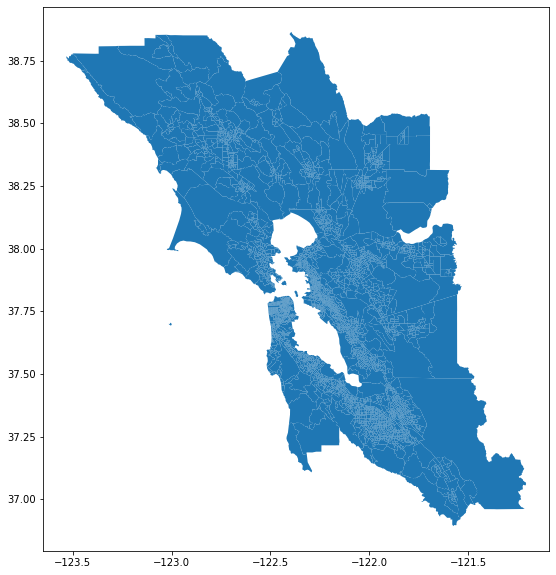

In [46]:
tracts_2018.plot(figsize=(10,10));

In [47]:
tracts_2018['tract_geoid'] = tracts_2018['GEOID'].str.slice(start=0,stop=11)

In [48]:
tracts_2018.rename(columns={'GEOID':'block_geoid'},inplace=True)

In [49]:
tracts_2018.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 4750 entries, 0 to 4749
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   geometry     4750 non-null   geometry
 1   block_geoid  4750 non-null   object  
 2   BLKGRP       4750 non-null   object  
 3   tract_geoid  4750 non-null   object  
dtypes: geometry(1), object(3)
memory usage: 148.6+ KB


### Join 2020 resource areas to tracts and block groups

In [50]:
resource_areas.head(5)

,tract_geoid,block_geoid,County,County ID,Region,Economic Domain Score (by region),Environmental Domain Score (by region),Education Domain Score (by region),Composite Index Score,Final Category
0,06001400100,NaN,Alameda,06001,Bay Area Region,0.826,0.406,0.736,0.433,High Resource
1,06001400200,NaN,Alameda,06001,Bay Area Region,0.935,0.754,0.794,0.683,Highest Resource
2,06001400300,NaN,Alameda,06001,Bay Area Region,0.911,0.741,0.340,0.235,High Resource
3,06001400400,NaN,Alameda,06001,Bay Area Region,0.877,0.747,0.429,0.289,High Resource
4,06001400500,NaN,Alameda,06001,Bay Area Region,0.802,0.865,0.586,0.397,High Resource


In [51]:
tracts_2018.head(5)

,geometry,block_geoid,BLKGRP,tract_geoid
0,"POLYGON ((-123.01392 37.70035, -123.01278 37.6...",060759804011,1,06075980401
1,"POLYGON ((-122.39362 37.78308, -122.39053 37.7...",060750615006,6,06075061500
2,"POLYGON ((-122.41563 37.71273, -122.41600 37.7...",060750264011,1,06075026401
3,"POLYGON ((-121.85576 37.48454, -121.85529 37.4...",060855135001,1,06085513500
4,"POLYGON ((-122.25395 37.86574, -122.25374 37.8...",060014237003,3,06001423700


In [52]:
#Subset resource areas that are tract level only
resource_areas_tract_sub = resource_areas[resource_areas['block_geoid'].isnull()]

In [53]:
resource_areas_tract_sub.shape

(7051, 10)

In [54]:
#Join to resource area tract data
resource_areas_tracts = pd.merge(tracts_2018,
                                 resource_areas_tract_sub,
                                 on='tract_geoid',
                                 how='inner')

In [55]:
resource_areas_tracts.groupby('tract_geoid').size().shape

(1507,)

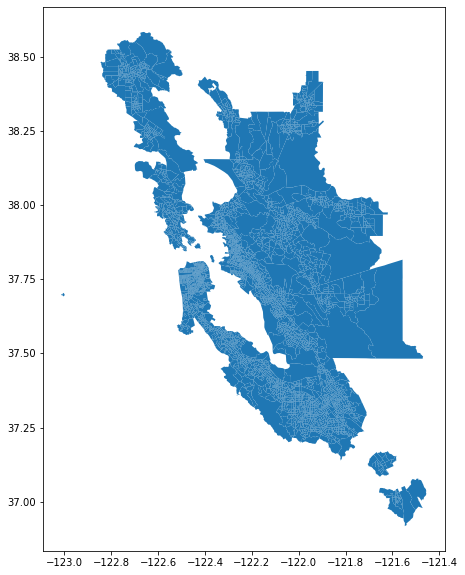

In [56]:
resource_areas_tracts.plot(figsize=(10,10));

In [57]:
resource_areas_tracts.head(5)

,geometry,block_geoid_x,BLKGRP,tract_geoid,block_geoid_y,County,County ID,Region,Economic Domain Score (by region),Environmental Domain Score (by region),Education Domain Score (by region),Composite Index Score,Final Category
0,"POLYGON ((-123.01392 37.70035, -123.01278 37.6...",060759804011,1,06075980401,NaN,San Francisco,06075,Bay Area Region,NaN,NaN,NaN,NaN,NaN
1,"POLYGON ((-122.39362 37.78308, -122.39053 37.7...",060750615006,6,06075061500,NaN,San Francisco,06075,Bay Area Region,0.929,0.049,0.347,-0.028,Moderate Resource
2,"POLYGON ((-122.40047 37.78503, -122.39893 37.7...",060750615002,2,06075061500,NaN,San Francisco,06075,Bay Area Region,0.929,0.049,0.347,-0.028,Moderate Resource
3,"POLYGON ((-122.39516 37.78431, -122.39739 37.7...",060750615005,5,06075061500,NaN,San Francisco,06075,Bay Area Region,0.929,0.049,0.347,-0.028,Moderate Resource
4,"POLYGON ((-122.39448 37.78730, -122.39294 37.7...",060750615003,3,06075061500,NaN,San Francisco,06075,Bay Area Region,0.929,0.049,0.347,-0.028,Moderate Resource


In [58]:
#drop block geoid columns
resource_areas_tracts.drop(columns=['block_geoid_x','block_geoid_y'],inplace=True)

In [59]:
#dissove by tract
resource_area_tracts_diss = resource_areas_tracts.dissolve(by='tract_geoid').reset_index()

In [60]:
#Subset resource areas that are block level 
resource_areas_blkgrp_sub = resource_areas[resource_areas['block_geoid'].notnull()]

In [61]:
#Join to resource area tract data
resource_areas_blockgp = pd.merge(tracts_2018,
                                 resource_areas_blkgrp_sub,
                                 on='block_geoid',
                                 how='inner')

In [62]:
resource_areas_blockgp.head(5)

,geometry,block_geoid,BLKGRP,tract_geoid_x,tract_geoid_y,County,County ID,Region,Economic Domain Score (by region),Environmental Domain Score (by region),Education Domain Score (by region),Composite Index Score,Final Category
0,"POLYGON ((-121.85576 37.48454, -121.85529 37.4...",060855135001,1,06085513500,06085513500,Santa Clara,06085,Rural Areas,0.091,0.000,0.636,-0.421,Low Resource
1,"POLYGON ((-122.51468 38.34912, -122.51579 38.3...",060971505005,5,06097150500,06097150500,Sonoma,06097,Rural Areas,0.519,0.565,0.168,-0.217,Low Resource
2,"POLYGON ((-122.80740 38.55642, -122.80738 38.5...",060971538063,3,06097153806,06097153806,Sonoma,06097,Rural Areas,0.389,0.542,0.496,-0.003,Moderate Resource
3,"POLYGON ((-122.37021 38.40825, -122.36806 38.4...",060552013001,1,06055201300,06055201300,Napa,06055,Rural Areas,0.774,0.194,0.226,0.020,High Resource
4,"POLYGON ((-122.47059 38.27693, -122.47197 38.2...",060971502031,1,06097150203,06097150203,Sonoma,06097,Rural Areas,0.427,0.344,0.046,-0.375,Low Resource


In [63]:
resource_areas_blockgp.groupby('tract_geoid_x').size().shape

(75,)

In [64]:
resource_areas_blockgp.drop(columns='tract_geoid_y',inplace=True)

In [65]:
resource_areas_blockgp.rename(columns={'tract_geoid_x':'tract_geoid'},inplace=True)

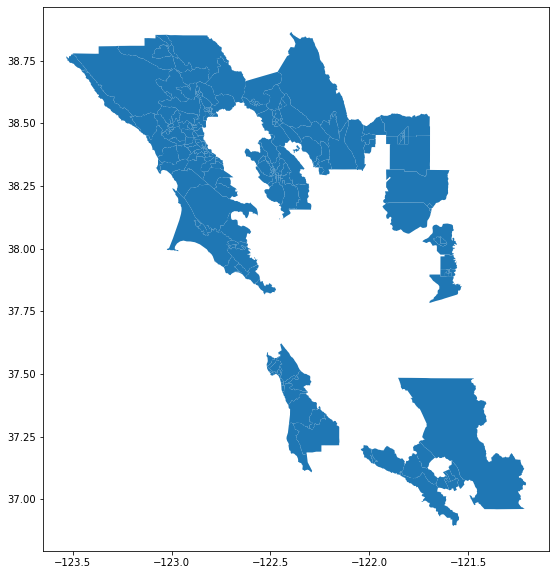

In [66]:
resource_areas_blockgp.plot(figsize=(10,10));

In [67]:
#Append tracts and blocks together
resource_areas_tracts_blocks = resource_area_tracts_diss.append(resource_areas_blockgp,ignore_index=True)

In [68]:
resource_areas_tracts_blocks.groupby('tract_geoid').head(5)

,tract_geoid,geometry,BLKGRP,County,County ID,Region,Economic Domain Score (by region),Environmental Domain Score (by region),Education Domain Score (by region),Composite Index Score,Final Category,block_geoid
0,06001400100,"POLYGON ((-122.24692 37.88544, -122.24683 37.8...",1,Alameda,06001,Bay Area Region,0.826,0.406,0.736,0.433,High Resource,NaN
1,06001400200,"POLYGON ((-122.24404 37.85026, -122.24332 37.8...",1,Alameda,06001,Bay Area Region,0.935,0.754,0.794,0.683,Highest Resource,NaN
2,06001400300,"POLYGON ((-122.24813 37.84139, -122.25081 37.8...",1,Alameda,06001,Bay Area Region,0.911,0.741,0.340,0.235,High Resource,NaN
3,06001400400,"POLYGON ((-122.25620 37.84469, -122.25742 37.8...",2,Alameda,06001,Bay Area Region,0.877,0.747,0.429,0.289,High Resource,NaN
4,06001400500,"POLYGON ((-122.26514 37.84453, -122.26807 37.8...",3,Alameda,06001,Bay Area Region,0.802,0.865,0.586,0.397,High Resource,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
1749,06097153801,"POLYGON ((-122.83718 38.55645, -122.83725 38.5...",4,Sonoma,06097,Rural Areas,0.687,0.000,0.420,-0.119,Moderate Resource,060971538014
1750,06097150202,"POLYGON ((-122.44935 38.29473, -122.44991 38.2...",3,Sonoma,06097,Rural Areas,0.931,0.427,0.298,0.118,High Resource,060971502023
1752,06055201601,"POLYGON ((-122.46663 38.50341, -122.46687 38.5...",2,Napa,06055,Rural Areas,0.097,0.000,0.871,-0.222,Moderate Resource,060552016012
1753,06097153703,"POLYGON ((-123.08922 38.53874, -123.08973 38.5...",1,Sonoma,06097,Rural Areas,0.130,0.786,0.382,-0.181,Moderate Resource,060971537031


In [69]:
resource_areas_tracts_blocks.groupby('tract_geoid').size().shape

(1582,)

In [70]:
columns_list = resource_areas_tracts_blocks.columns.to_list()

In [71]:
dict.fromkeys(columns_list)

{'tract_geoid': None,
 'geometry': None,
 'BLKGRP': None,
 'County': None,
 'County ID': None,
 'Region': None,
 'Economic Domain Score (by region)': None,
 'Environmental Domain Score (by region)': None,
 'Education Domain Score (by region)': None,
 'Composite Index Score': None,
 'Final Category': None,
 'block_geoid': None}

In [72]:
rename_cols = {'tract_geoid': 'tract_geoi',
               'block_geoid': 'block_geoi',
               'BLKGRP': 'blck_group',
               'County': 'county',
               'County ID': 'county_id',
               'Region': 'region',
               'Economic Domain Score (by region)': 'econ_domai',
               'Environmental Domain Score (by region)': 'envi_domai',
               'Education Domain Score (by region)': 'educ_domain',
               'Composite Index Score': 'cpi',
               'Final Category': 'f_category'}
resource_areas_tracts_blocks.rename(columns=rename_cols,inplace=True)

In [73]:
resource_areas_tracts_blocks.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1756 entries, 0 to 1755
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   tract_geoi   1756 non-null   object  
 1   geometry     1756 non-null   geometry
 2   blck_group   1756 non-null   object  
 3   county       1756 non-null   object  
 4   county_id    1756 non-null   object  
 5   region       1756 non-null   object  
 6   econ_domai   1739 non-null   float64 
 7   envi_domai   1739 non-null   float64 
 8   educ_domain  1739 non-null   float64 
 9   cpi          1699 non-null   float64 
 10  f_category   1739 non-null   object  
 11  block_geoi   249 non-null    object  
dtypes: float64(4), geometry(1), object(7)
memory usage: 164.8+ KB


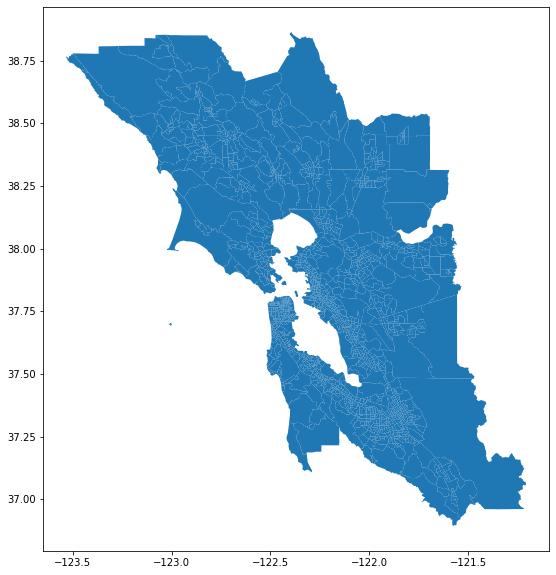

In [74]:
resource_areas_tracts_blocks.plot(figsize=(10,10));

In [75]:
ls 'temp_data/'

ls: temp_data/: No such file or directory


In [76]:
# resource_areas_tracts.to_file('temp_data/hcd_tcac_resource_opportunity_areas_2020.geojson',
#                               driver='GeoJSON')

### Upsert to enterprise portal

In [77]:
resource_areas_tracts_sdf = pd.DataFrame.spatial.from_geodataframe(resource_areas_tracts_blocks,
                                                                   column_name='geometry')

In [78]:
resource_areas_tracts_sdf.spatial.sr

{'wkid': 4326}

In [79]:
resource_areas_tracts_sdf.head(5)

,tract_geoi,blck_group,county,county_id,region,econ_domai,envi_domai,educ_domain,cpi,f_category,block_geoi,geometry
0,06001400100,1,Alameda,06001,Bay Area Region,0.826,0.406,0.736,0.433,High Resource,NaN,"{""rings"": [[[-122.24691999958634, 37.885438000..."
1,06001400200,1,Alameda,06001,Bay Area Region,0.935,0.754,0.794,0.683,Highest Resource,NaN,"{""rings"": [[[-122.24404400008507, 37.850256999..."
2,06001400300,1,Alameda,06001,Bay Area Region,0.911,0.741,0.340,0.235,High Resource,NaN,"{""rings"": [[[-122.24812999973132, 37.841391999..."
3,06001400400,2,Alameda,06001,Bay Area Region,0.877,0.747,0.429,0.289,High Resource,NaN,"{""rings"": [[[-122.25620499983769, 37.844686000..."
4,06001400500,3,Alameda,06001,Bay Area Region,0.802,0.865,0.586,0.397,High Resource,NaN,"{""rings"": [[[-122.26514000028475, 37.844529999..."


In [80]:
resource_areas_tracts_sdf.spatial.plot()

MapView(layout=Layout(height='400px', width='100%'))

In [81]:
title = 'CTCAC HCD Resource Opportunity Areas 2020 v2'
ra_lyr = resource_areas_tracts_sdf.spatial.to_featurelayer(title,folder='Data Staging')
ra_lyr

<Item title:"CTCAC HCD Resource Opportunity Areas 2020 v2" type:Feature Layer Collection owner:jcroff>

In [86]:
#Search for layer
resource_area_item = gis.content.get('6dfb1643aabc499fa938f100edf1592d')

In [87]:
resource_area_item.layers[0].properties

{
  "currentVersion": 10.8,
  "cimVersion": "2.5.0",
  "id": 0,
  "name": "k9fa66",
  "type": "Feature Layer",
  "parentLayer": null,
  "defaultVisibility": true,
  "minScale": 4622325,
  "maxScale": 2256,
  "canScaleSymbols": false,
  "geometryType": "esriGeometryPolygon",
  "description": "",
  "copyrightText": "",
  "editFieldsInfo": null,
  "syncCanReturnChanges": true,
  "relationships": [],
  "isDataVersioned": false,
  "isDataArchived": false,
  "isDataBranchVersioned": false,
  "isCoGoEnabled": false,
  "supportsRollbackOnFailureParameter": true,
  "supportsStatistics": true,
  "supportsAdvancedQueries": true,
  "supportsValidateSQL": true,
  "supportsCoordinatesQuantization": true,
  "supportsCalculate": true,
  "supportsASyncCalculate": true,
  "advancedQueryCapabilities": {
    "supportsReturningQueryExtent": true,
    "supportsStatistics": true,
    "supportsDistinct": true,
    "supportsPagination": true,
    "supportsOrderBy": true,
    "supportsQueryWithDistance": true,


In [61]:
#Get groups
groups = gis.groups.search('title: staging')
groups

[<Group title:"Staging_for_Enterprise_Groups (Private - Working)" owner:msmith>]

In [62]:
#Get staging group id
staging_id = groups[0].groupid
staging_id

'd5a7077090d64d42a2b07b55c714f93a'

In [63]:
#Share with staging group
resource_area_2020_item.share(groups=staging_id)

{'results': [{'itemId': 'a6f295ce96df428f9b99542c089d9039',
   'success': True,
   'notSharedWith': []}]}